In [2]:
!pip install pingouin

   ---------------------------------------- 0.0/198.9 kB ? eta -:--:--
   -- ------------------------------------- 10.2/198.9 kB ? eta -:--:--
   ------------ -------------------------- 61.4/198.9 kB 656.4 kB/s eta 0:00:01
   ----------------------------------- ---- 174.1/198.9 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 198.9/198.9 kB 1.2 MB/s eta 0:00:00


In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticsRegression
from sklearn.metrics import classification_report, precision_score

import pingouin

ImportError: cannot import name 'LogisticsRegression' from 'sklearn.linear_model' (C:\Users\UTTPAL\anaconda files\Lib\site-packages\sklearn\linear_model\__init__.py)

In [3]:
sns.set_style('whitegrid')
rcParams['figure.figsize'] = [7,5]
rcParams['axes.titlesize'] = 14
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = 13
rcParams['axes.labelweight'] = 'bold'

# DATA READING:

In [6]:
hr_data = pd.read_csv(r"D:\CTTC files\Datasets for practice\archive (3)\HR_comma_sep.csv")
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [9]:
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [11]:
hr_data = hr_data.rename(columns={'average_montly_hours':'average_monthly_hours'})


In [13]:
prob_leaving_list=[]
np.random.seed(987)
for i in range(1000):
      prob_leaving_list.append(hr_data.sample(frac = 1.0, replace = True)['left'].value_counts(normalize = True)[1])

prob_leaving = np.mean(prob_leaving_list)
print(f'Probability of an employee leaving is {100*prob_leaving:,.2f}%')
    

Probability of an employee leaving is 23.83%


# DATA VISUALIZATION:

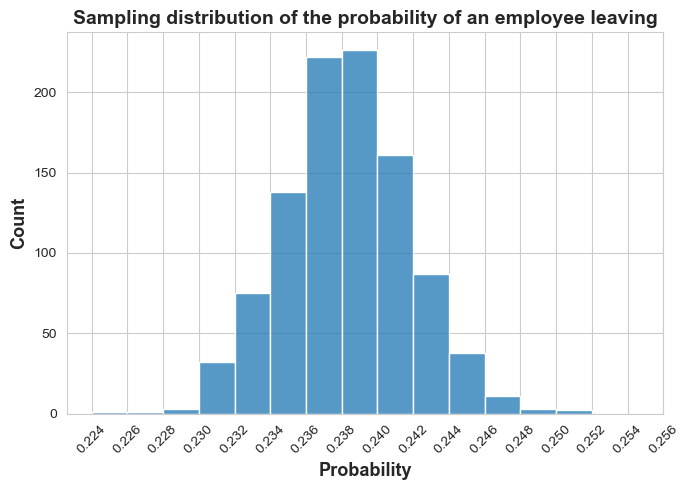

In [15]:
sns.histplot(prob_leaving_list, bins = np.arange(0.224,0.254, 0.002))
plt.title('Sampling distribution of the probability of an employee leaving')
plt.ylabel('Count')
plt.xlabel('Probability')
plt.xticks(np.arange(0.224,0.258, 0.002), rotation = 45)
plt.tight_layout()
plt.show()

### Confidence Interval

In [17]:
lower_quant = np.quantile(prob_leaving_list, 0.025)
upper_quant = np.quantile(prob_leaving_list, 0.975)
print(f'Lower limit is {lower_quant:,.5f} and upper limit is {upper_quant:,.5f}')

Lower limit is 0.23135 and upper limit is 0.24522


In [19]:
point_estimate = np.mean(prob_leaving_list)
standard_error = np.std(prob_leaving_list, ddof = 1)
lower_se = norm.ppf(0.025, loc = point_estimate, scale = standard_error)
upper_se = norm.ppf(0.975, loc = point_estimate, scale = standard_error)
print(f'We can say with 95% confidence that the probability of an employee leaving is between {100*lower_se:,.2f}% and {100*upper_se:,.2f}%')

We can say with 95% confidence that the probability of an employee leaving is between 23.14% and 24.51%


### Salary:

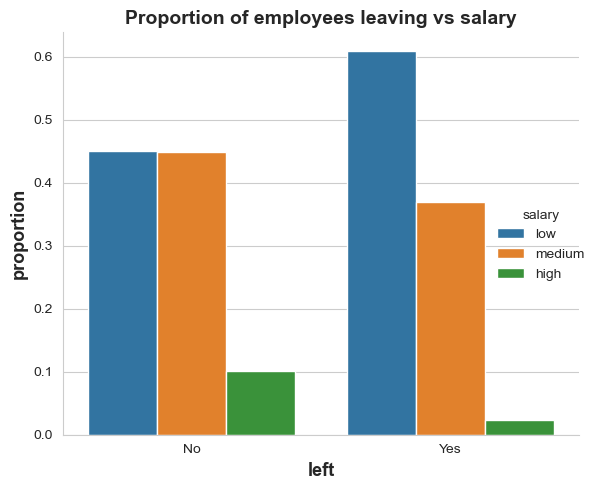

In [27]:
hr_salary = pd.DataFrame(hr_data.groupby('left').salary.value_counts(normalize = True))
hr_salary.columns = ['proportion']
hr_salary = hr_salary.reset_index()

sns.catplot(x = 'left', y = 'proportion', hue = 'salary', data = hr_salary, kind = 'bar')
plt.xticks([0,1],['No','Yes'])
plt.title('Proportion of employees leaving vs salary')
plt.tight_layout()
plt.show()

### Promotion in last 5 years:

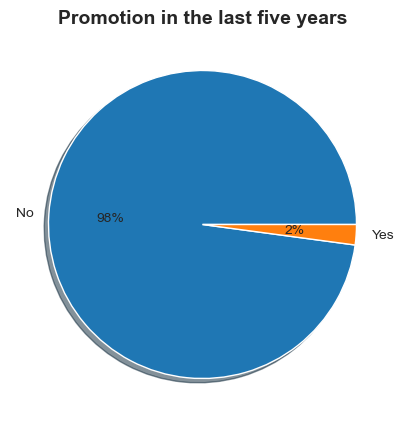

In [29]:
plt.pie(hr_data.promotion_last_5years.value_counts(), autopct = '%.0f%%', labels = ['No','Yes'], shadow = True)
plt.title('Promotion in the last five years')
plt.show()

### Sales:

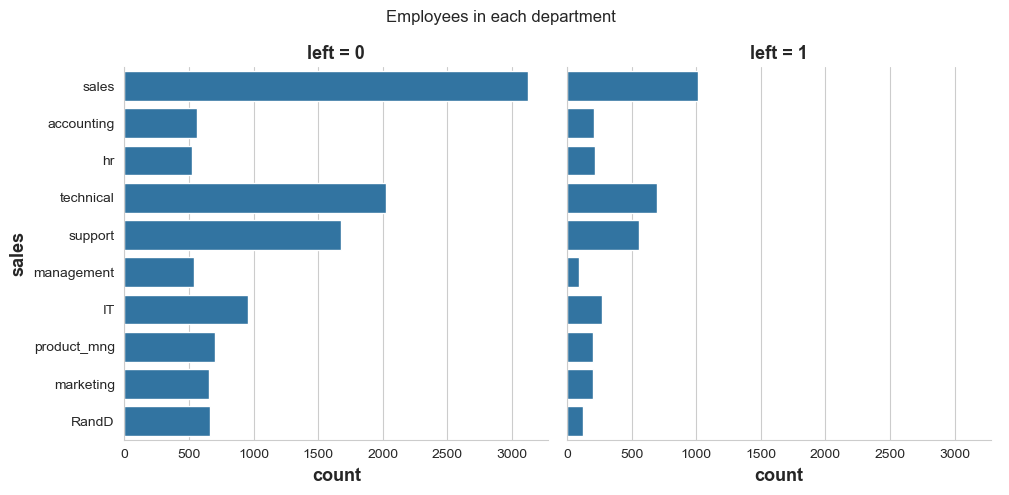

In [31]:
g = sns.catplot(y = 'sales', data = hr_data, kind = 'count', col = 'left')
g.fig.suptitle('Employees in each department')
plt.tight_layout()
plt.show()

### Last Evaluation:

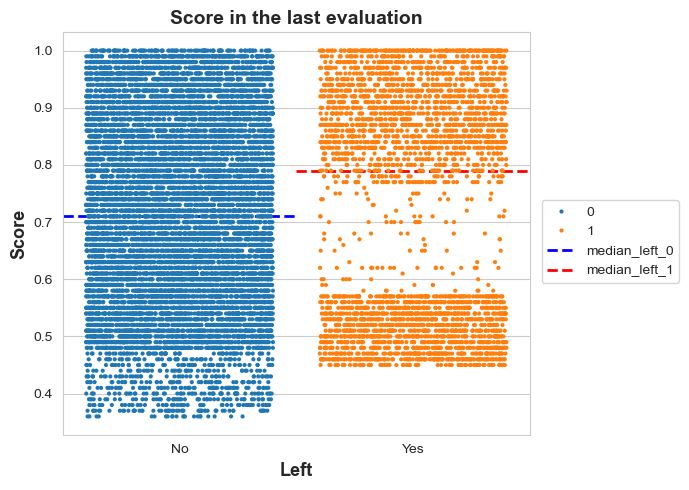

In [33]:
sns.stripplot(x = 'left', y = 'last_evaluation', data = hr_data, hue = 'left', jitter = 0.4, size = 3)
plt.title('Score in the last evaluation')
plt.ylabel('Score')
plt.xlabel('Left')
plt.axhline(hr_data.loc[hr_data.left == 0, 'last_evaluation'].median(),xmin = 0, xmax=0.5, ls = '--', lw =2, color = 'blue', label = 'median_left_0')
plt.axhline(hr_data.loc[hr_data.left == 1, 'last_evaluation'].median(),xmin = 0.5, xmax=1, ls = '--', lw =2, color = 'red', label = 'median_left_1')
plt.xticks([0,1],['No','Yes'])
#plt.ylim([0,1.2])
plt.legend(bbox_to_anchor = [1.01,0.6])
plt.tight_layout()
plt.show()

### Work Accident:

In [40]:
hr_data.groupby('left')['Work_accident'].value_counts(normalize = True)*100

left  Work_accident
0     0                82.499125
      1                17.500875
1     0                95.267432
      1                 4.732568
Name: proportion, dtype: float64

### Satisfaction Level vs salary

In [43]:
hr_data.pivot_table(index = 'salary', columns = 'left', values = 'satisfaction_level', aggfunc = 'median')


left,0,1
salary,,
high,0.67,0.43
low,0.69,0.41
medium,0.69,0.41


### Satisfaction level vs Average Monthly Hours:

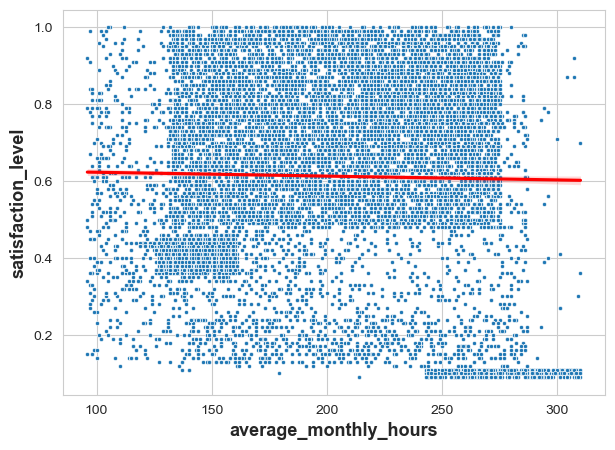

In [46]:
sns.scatterplot(x = 'average_monthly_hours', y = 'satisfaction_level', data = hr_data, marker = '.')
sns.regplot(x = 'average_monthly_hours', y = 'satisfaction_level', data = hr_data, scatter = False, color = 'red')
plt.show()

### Satisfaction level vs promotion:

In [49]:
hr_data.pivot_table(index = 'promotion_last_5years', columns = 'left', values = 'satisfaction_level', aggfunc = 'median')

left,0,1
promotion_last_5years,,
0,0.690,0.41
1,0.695,0.44


# PREPROCESSING:

In [55]:
hr_data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [57]:
hr_data['promotion_last_5years'] = hr_data['promotion_last_5years'].astype('object')
hr_data['Work_accident'] = hr_data['Work_accident'].astype('object')

In [59]:
X = hr_data.drop('left', axis = 1)
y = hr_data['left']
columns_numeric = X.select_dtypes(include = ['float', 'int']).columns.tolist()
columns_category = X.select_dtypes(include= ['object']).columns.tolist()

# MODEL TRAINING:

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 987)

In [64]:
class Dictifier(BaseEstimator, TransformerMixin):
    "The dictifier class converts a dataframe to a dictionary to allow using the dict vectorizer transformer"
    def __init__(self):
        pass

    def fit(self, df):
        """Mock method"""
        return self

    def transform(self, df):
        return df.to_dict('records')

# STANDARDIZATION & ENCODING:

In [67]:
cat_steps = [('dictifier',Dictifier()),('vectorizer',DictVectorizer(sort = False, sparse = False))]
num_steps = [('scaler', StandardScaler())]  

num_pipe = Pipeline(num_steps)
cat_pipe = Pipeline(cat_steps)

x_train_cat_vec = cat_pipe.fit_transform(X_train[columns_category])
X_train_num_sc = num_pipe.fit_transform(X_train[columns_numeric])

x_test_cat_vec = cat_pipe.transform(X_test[columns_category])
X_test_num_sc = num_pipe.transform(X_test[columns_numeric])

In [69]:
X_train_cat = pd.DataFrame(x_train_cat_vec, columns = cat_pipe['vectorizer'].feature_names_)
X_train_num = pd.DataFrame(X_train_num_sc, columns = columns_numeric)

X_test_cat = pd.DataFrame(x_test_cat_vec, columns = cat_pipe['vectorizer'].feature_names_)
X_test_num = pd.DataFrame(X_test_num_sc, columns = columns_numeric)

X_train = pd.concat([X_train_num, X_train_cat], axis = 1)
X_test = pd.concat([X_test_num, X_test_cat], axis = 1)

# DIFFERENT MODELS WITH ACCURACY:

In [72]:
logreg = LogisticRegression()
xgb_cl = xgb.XGBClassifier()
svc = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
dt = DecisionTreeClassifier()

classifiers = [('Logistic Regression',logreg),('Xgboost',xgb_cl),('Support vector',svc),
               ('K_Neighbors',knn),('Random forest',rf),('Decision tree',dt),('Adaboost',ada)]

accuracy_score = []
for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = (y_pred == y_test).sum()/len(y_test)
    accuracy_score.append({'classifier':clf_name, 'accuracy':accuracy})

accuracy_df = pd.DataFrame(accuracy_score)
accuracy_df.sort_values(by='accuracy', ascending = False)

C:\Users\UTTPAL\anaconda files\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,classifier,accuracy
4,Random forest,0.991467
1,Xgboost,0.990133
5,Decision tree,0.978133
2,Support vector,0.967467
6,Adaboost,0.960533
3,K_Neighbors,0.948533
0,Logistic Regression,0.792533


In [74]:
random_forest = RandomForestClassifier(random_state = 987)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
accuracy = (y_pred == y_test).sum()/len(y_test)
print(f'The random forest classifier has an accuracy of {accuracy}')

The random forest classifier has an accuracy of 0.9909333333333333


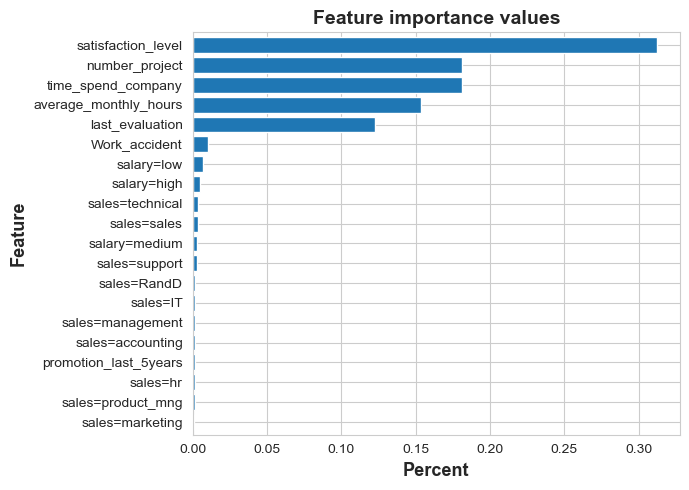

In [76]:
pd.Series(rf.feature_importances_, index = rf.feature_names_in_).sort_values().plot(kind='barh', width = 0.8)
plt.xlabel('Percent')
plt.ylabel('Feature')
plt.title('Feature importance values')
plt.tight_layout()
plt.show()

xgboost has an accuracy of 0.9901333333333333


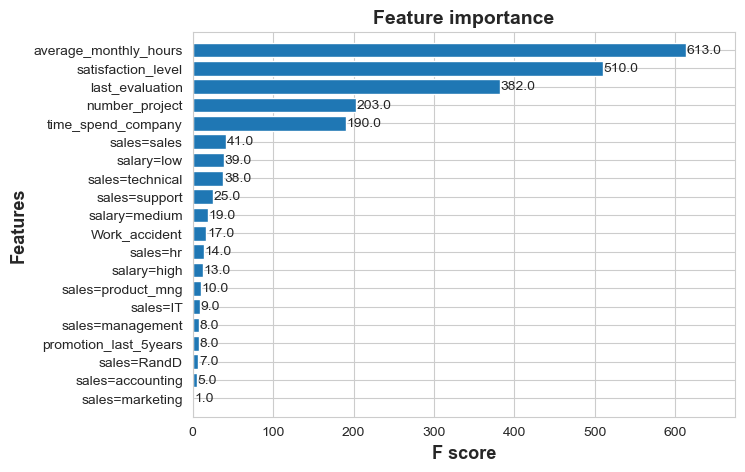

In [78]:
xgb_cl = xgb.XGBClassifier(objective= 'binary:logistic', random_state = 987)
xgb_cl.fit(X_train, y_train)
y_pred = xgb_cl.predict(X_test)
accuracy = (y_pred == y_test).sum()/len(y_test)
print(f'xgboost has an accuracy of {accuracy}')

xgb.plot_importance(xgb_cl, height = 0.8)
plt.show()

In [80]:
xgboost_cl = xgb.XGBClassifier(objective= 'binary:logistic', random_state = 987)
random_forest = RandomForestClassifier(random_state = 987)

features = ['average_monthly_hours','satisfaction_level','last_evaluation','number_project','time_spend_company']
classifiers = [('xgboost',xgboost_cl),('random forest',random_forest)]

for clf_name, clf in classifiers:
    clf.fit(X_train[features], y_train)
    y_pred = clf.predict(X_test[features])
    accuracy = (y_pred == y_test).sum()/len(y_test)
    print(f'{clf_name} has an accuracy of {accuracy:,.4f}')

xgboost has an accuracy of 0.9891
random forest has an accuracy of 0.9923


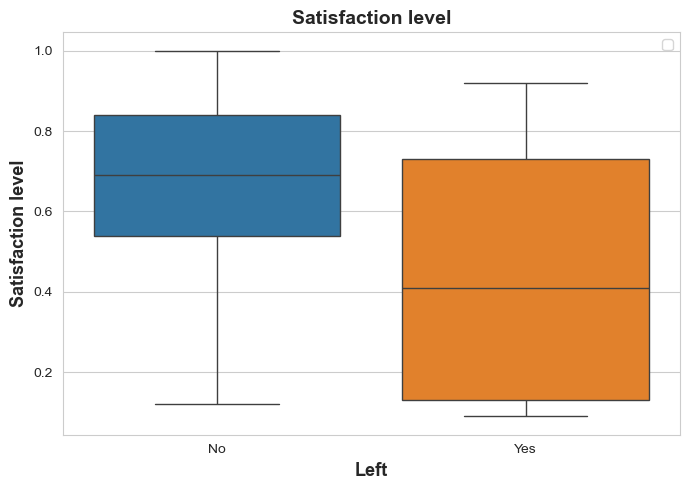

In [82]:
sns.boxplot(x = 'left', y = 'satisfaction_level', data = hr_data, hue = 'left')
plt.title('Satisfaction level')
plt.xlabel('Left')
plt.ylabel('Satisfaction level')
plt.xticks([0,1],['No','Yes'])
plt.legend("")
plt.tight_layout()
plt.show()

In [84]:
pingouin.anova(dv = 'satisfaction_level', between = 'left',data = hr_data)

,Source,ddof1,ddof2,F,p-unc,np2
0,left,1,14997,2663.881285,0.0,0.150835


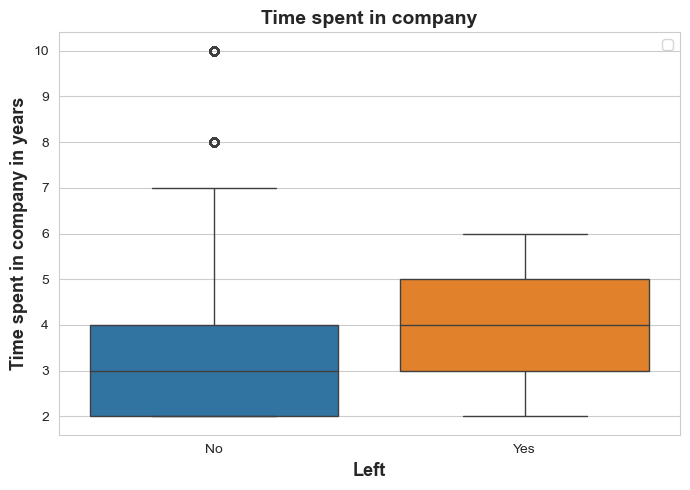

,count,mean,std,min,25%,50%,75%,max
left,,,,,,,,
0,11428.0,3.380032,1.562348,2.0,2.0,3.0,4.0,10.0
1,3571.0,3.876505,0.977698,2.0,3.0,4.0,5.0,6.0


In [86]:
sns.boxplot(y='time_spend_company',x='left', data = hr_data, hue = 'left')
plt.xlabel('Left')
plt.ylabel('Time spent in company in years')
plt.title('Time spent in company')
plt.xticks([0,1],['No','Yes'])
plt.legend("")
plt.tight_layout()
plt.show()

hr_data.groupby('left')['time_spend_company'].describe()

In [88]:
pingouin.anova(data = hr_data, dv = 'time_spend_company', between = 'left')

,Source,ddof1,ddof2,F,p-unc,np2
0,left,1,14997,321.277313,4.207680e-71,0.020973


,count,mean,std,min,0%,10%,30%,40%,50%,60%,70%,90%,max
left,,,,,,,,,,,,,
0,11428.0,3.786664,0.979884,2.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,5.0,6.0
1,3571.0,3.855503,1.818165,2.0,2.0,2.0,2.0,2.0,4.0,5.0,5.0,6.0,7.0


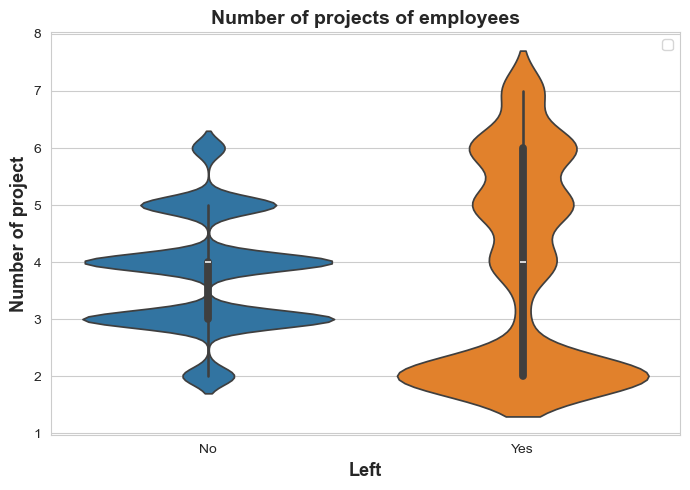

In [90]:
display(hr_data.groupby('left')['number_project'].describe(percentiles=[0,.1,.3,.4,.6,.7,.9]))
print()
sns.violinplot(x = 'left', y = 'number_project', data = hr_data, hue = 'left')
plt.ylabel('Number of project')
plt.xlabel('Left')
plt.title('Number of projects of employees')
plt.xticks([0,1],['No','Yes'])
plt.legend("")
plt.tight_layout()
plt.show()

In [92]:
proj_left = hr_data.loc[hr_data.left == 1, 'number_project']
proj_stay = hr_data.loc[hr_data.left == 0, 'number_project']

pingouin.ttest(x = proj_left, y = proj_stay, alternative = 'two-sided', paired = False, confidence = 0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.166342,4236.542893,two-sided,0.030341,"[0.01, 0.13]",0.055862,0.225,0.829884


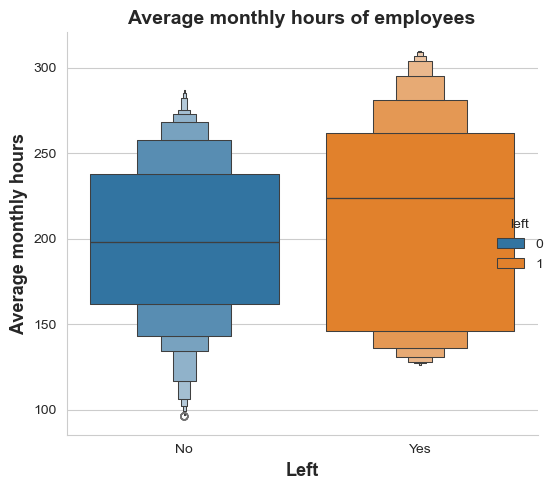


        count        mean        std    min    25%    50%    75%    max
left                                                                   
0     11428.0  199.060203  45.682731   96.0  162.0  198.0  238.0  287.0
1      3571.0  207.419210  61.202825  126.0  146.0  224.0  262.0  310.0


In [94]:
sns.catplot(x = 'left', y = 'average_monthly_hours', data = hr_data, kind = 'boxen', hue='left')
plt.title('Average monthly hours of employees')
plt.xlabel('Left')
plt.ylabel('Average monthly hours')
plt.xticks([0,1],['No','Yes'])
plt.tight_layout()
plt.show()
print()
print(hr_data.groupby('left')['average_monthly_hours'].describe())

In [96]:
left_employees_hours = hr_data[hr_data['left'] == 1]['average_monthly_hours']
stayed_employees_hours = hr_data[hr_data['left'] == 0]['average_monthly_hours']

pingouin.ttest(x = left_employees_hours, y = stayed_employees_hours, alternative = 'greater', confidence = 0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.532289,4875.061919,greater,2.953527e-14,"[6.53, inf]",0.167792,8.236e+10,1.0


In [98]:
hr_data.groupby('left')['last_evaluation'].describe()
print()
pingouin.pairwise_tests(dv = 'last_evaluation', between = 'left', data = hr_data, alternative = 'two-sided')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,left,0,1,False,True,-0.725342,5154.893462,two-sided,0.468275,0.028,-0.015418


In [126]:
from sklearn.metrics import precision_score
lr = LogisticRegression()


In [128]:
lr.fit(X_train,y_train)
precision_score(y_train, lr.predict(X_train))

0.5910006715916722

In [130]:
from sklearn.linear_model import LogisticRegressionCV
lr_cv = LogisticRegression()

In [132]:
lr_cv.fit(X_train,y_train)
precision_score(y_train, lr_cv.predict(X_train))

0.5910006715916722

In [134]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2857
           1       0.61      0.35      0.45       893

    accuracy                           0.79      3750
   macro avg       0.72      0.64      0.66      3750
weighted avg       0.77      0.79      0.77      3750

